In [11]:
import numpy as np
import pandas as pd
import datetime
import dateutil

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

In [497]:
# fill na with median
def fill_na_median(ori):
    df = ori.copy()
    
    for col in df.columns:
        values = df[col].dropna()
        if len(values) == 0 or len(values) == len(df):
            continue
        med = np.median(values)
        df[med] = df[med].fillna(med)

    return df

In [4]:
def clean(ori):
    df = ori.copy()
    df["Date"] = [dateutil.parser.parse(date) for date in df["Date"]]
    df = fill_na_median(df)
    return df

In [5]:
# split into region
def split_region(df):
    regions = np.unique(df["Region"])

    df_region = {}
    for region in regions:
        df_region[region] = df[df["Region"] == region]
    
    return regions, df_region

In [6]:
fire = pd.read_csv("Nov_10/Historical_Wildfires.csv")
fire = clean(fire)

fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26406 entries, 0 to 26405
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Region                               26406 non-null  object        
 1   Date                                 26406 non-null  datetime64[ns]
 2   Estimated_fire_area                  26406 non-null  float64       
 3   Mean_estimated_fire_brightness       26406 non-null  float64       
 4   Mean_estimated_fire_radiative_power  26406 non-null  float64       
 5   Mean_confidence                      26406 non-null  float64       
 6   Std_confidence                       26406 non-null  float64       
 7   Var_confidence                       26406 non-null  float64       
 8   Count                                26406 non-null  int64         
 9   Replaced                             26406 non-null  object        
dtypes: datetim

In [7]:
regions, df_region = split_region(fire)

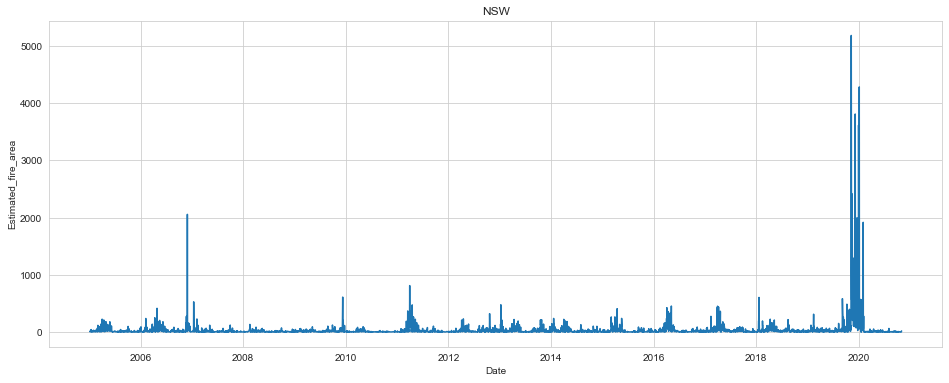

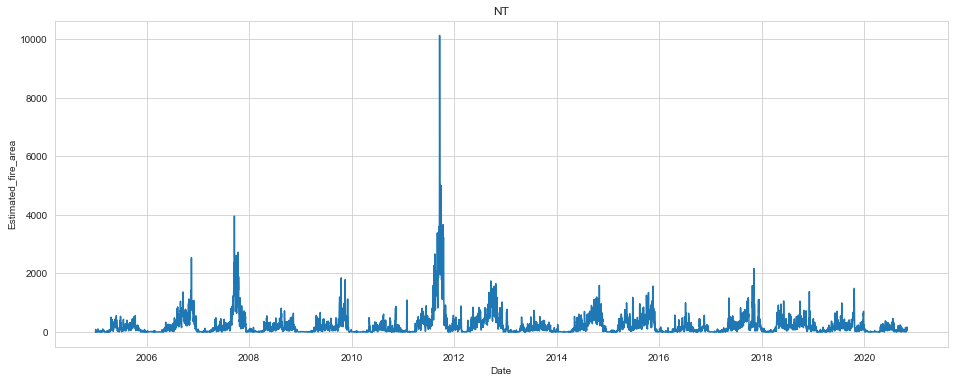

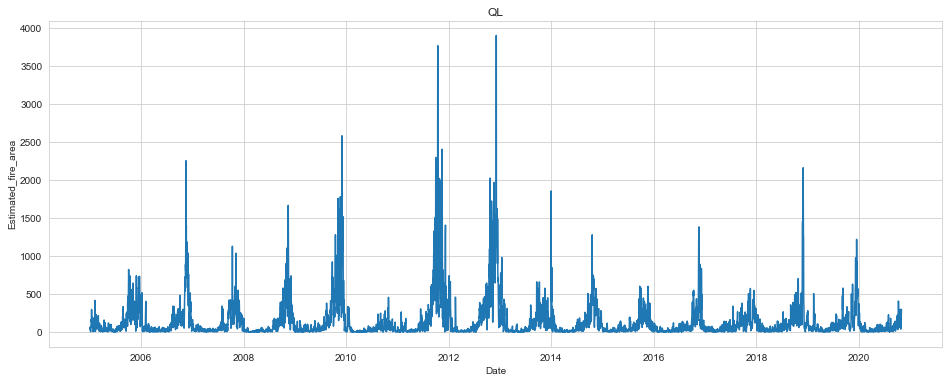

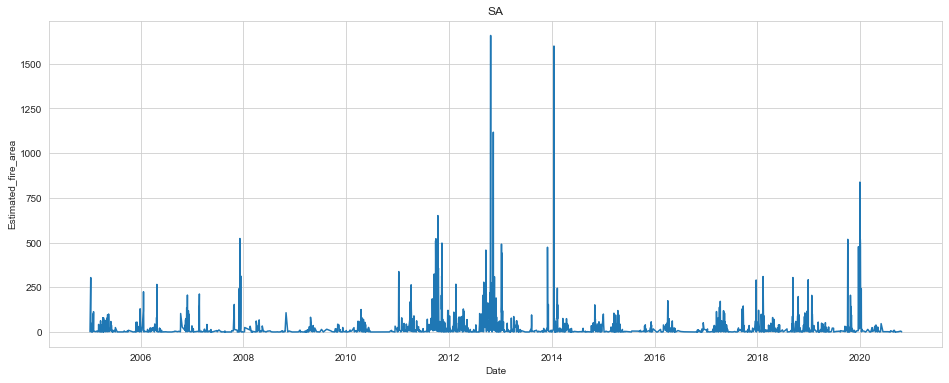

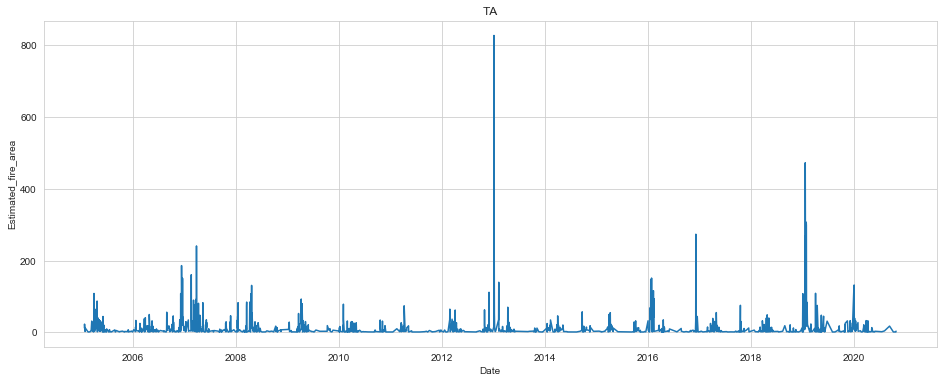

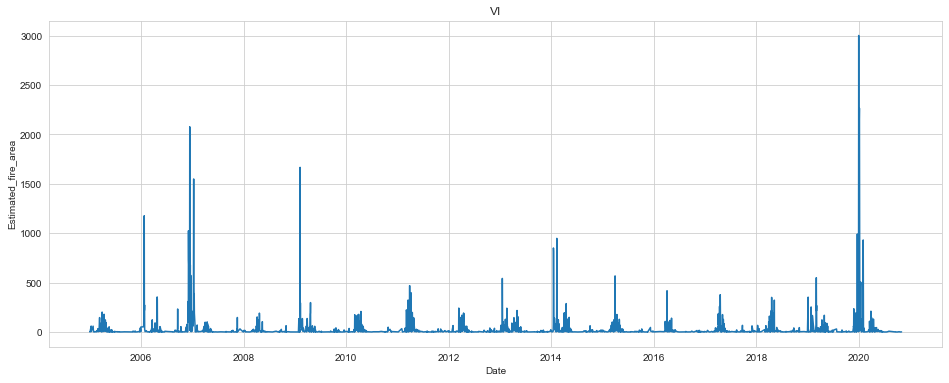

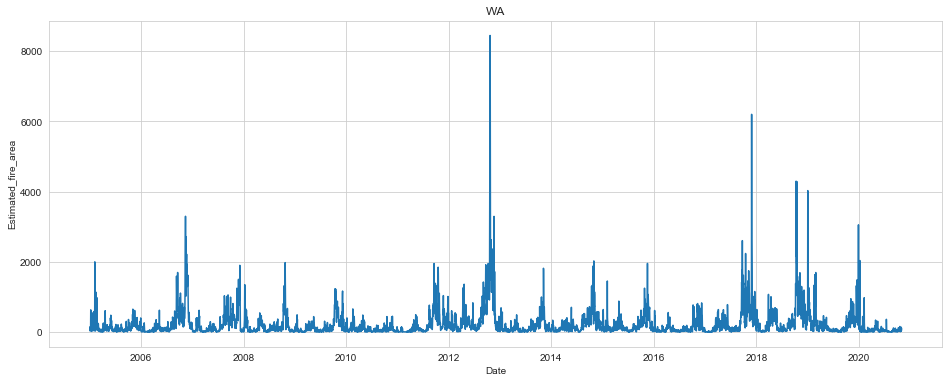

In [65]:
for region, df in df_region.items():
#     df_2010 = df[("1-1-2010" <= df["Date"]) & (df["Date"] < "1-1-2011")]
    
    plt.figure(figsize = (16, 6))
    sns.lineplot(x = "Date", y = "Estimated_fire_area", data = df)
    plt.title(region)

Text(0.5, 1.0, 'WA')

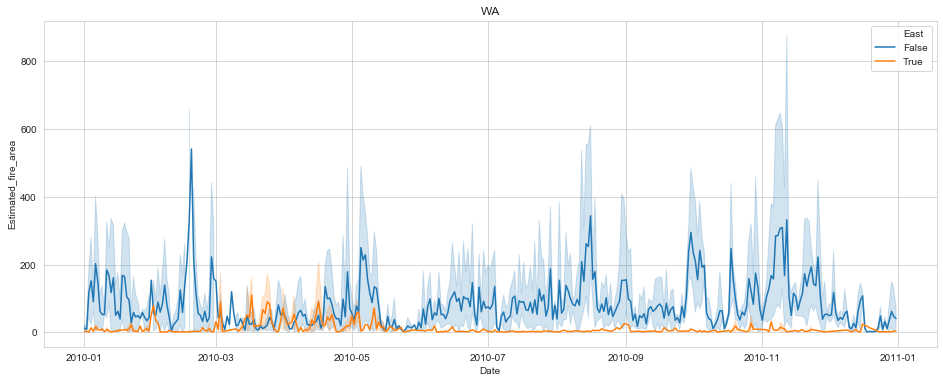

In [116]:
df = fire.copy()
df["East"] = df["Region"].isin(["NSW", "TA", "VI"])
df = df[("1-1-2010" <= df["Date"]) & (df["Date"] < "1-1-2011")]
    
plt.figure(figsize = (16, 6))
sns.lineplot(x = "Date", y = "Estimated_fire_area", data = df, hue = "East")
plt.title(region)

Text(0.5, 1.0, 'WA')

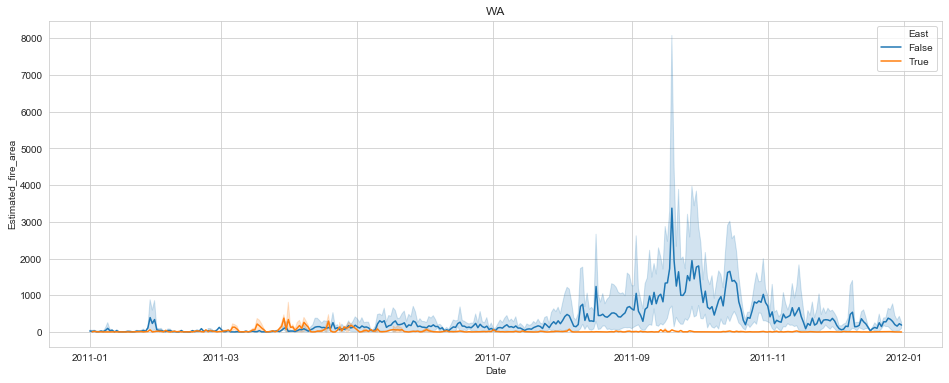

In [117]:
df = fire.copy()
df["East"] = df["Region"].isin(["NSW", "TA", "VI"])
df = df[("1-1-2011" <= df["Date"]) & (df["Date"] < "1-1-2012")]
    
plt.figure(figsize = (16, 6))
sns.lineplot(x = "Date", y = "Estimated_fire_area", data = df, hue = "East")
plt.title(region)

Text(0.5, 1.0, 'WA')

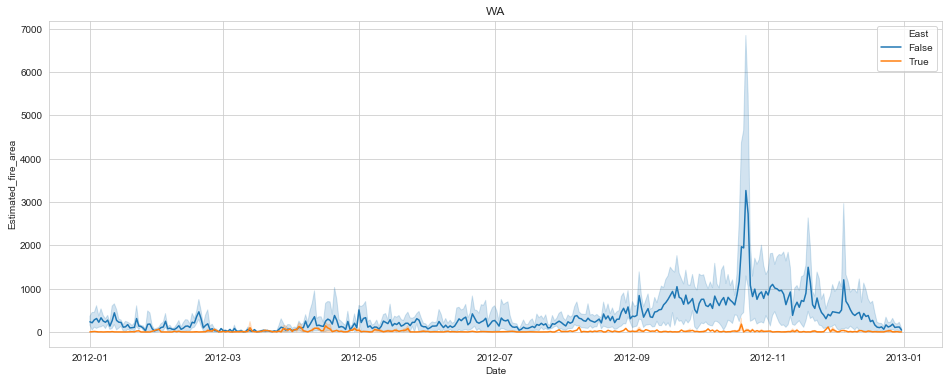

In [118]:
df = fire.copy()
df["East"] = df["Region"].isin(["NSW", "TA", "VI"])
df = df[("1-1-2012" <= df["Date"]) & (df["Date"] < "1-1-2013")]
    
plt.figure(figsize = (16, 6))
sns.lineplot(x = "Date", y = "Estimated_fire_area", data = df, hue = "East")
plt.title(region)

Text(0.5, 1.0, 'WA')

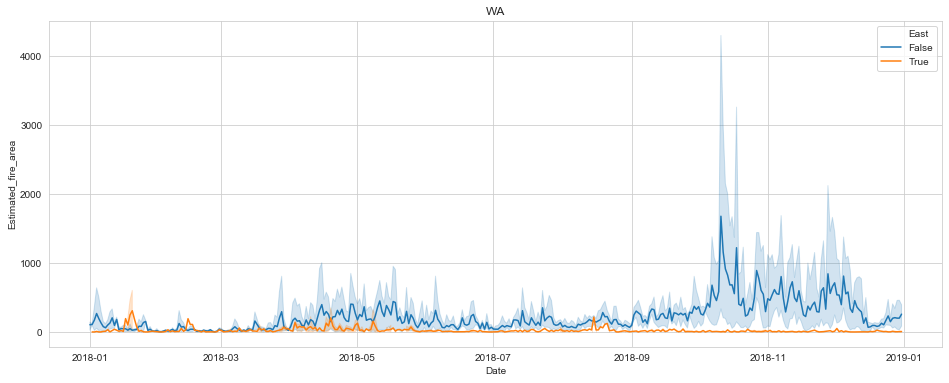

In [119]:
df = fire.copy()
df["East"] = df["Region"].isin(["NSW", "TA", "VI"])
df = df[("1-1-2018" <= df["Date"]) & (df["Date"] < "1-1-2019")]
    
plt.figure(figsize = (16, 6))
sns.lineplot(x = "Date", y = "Estimated_fire_area", data = df, hue = "East")
plt.title(region)

In [499]:
def period(df, days = 365, columns = None):
    if columns == None:
        columns = df.columns
    df = df.pivot_table(values = columns, 
                        index = "Date",
                        columns = "Region")
    df = df.reset_index().fillna(0)
    return df.groupby(pd.Grouper(key = "Date", freq = f"{days*24}h")).mean()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


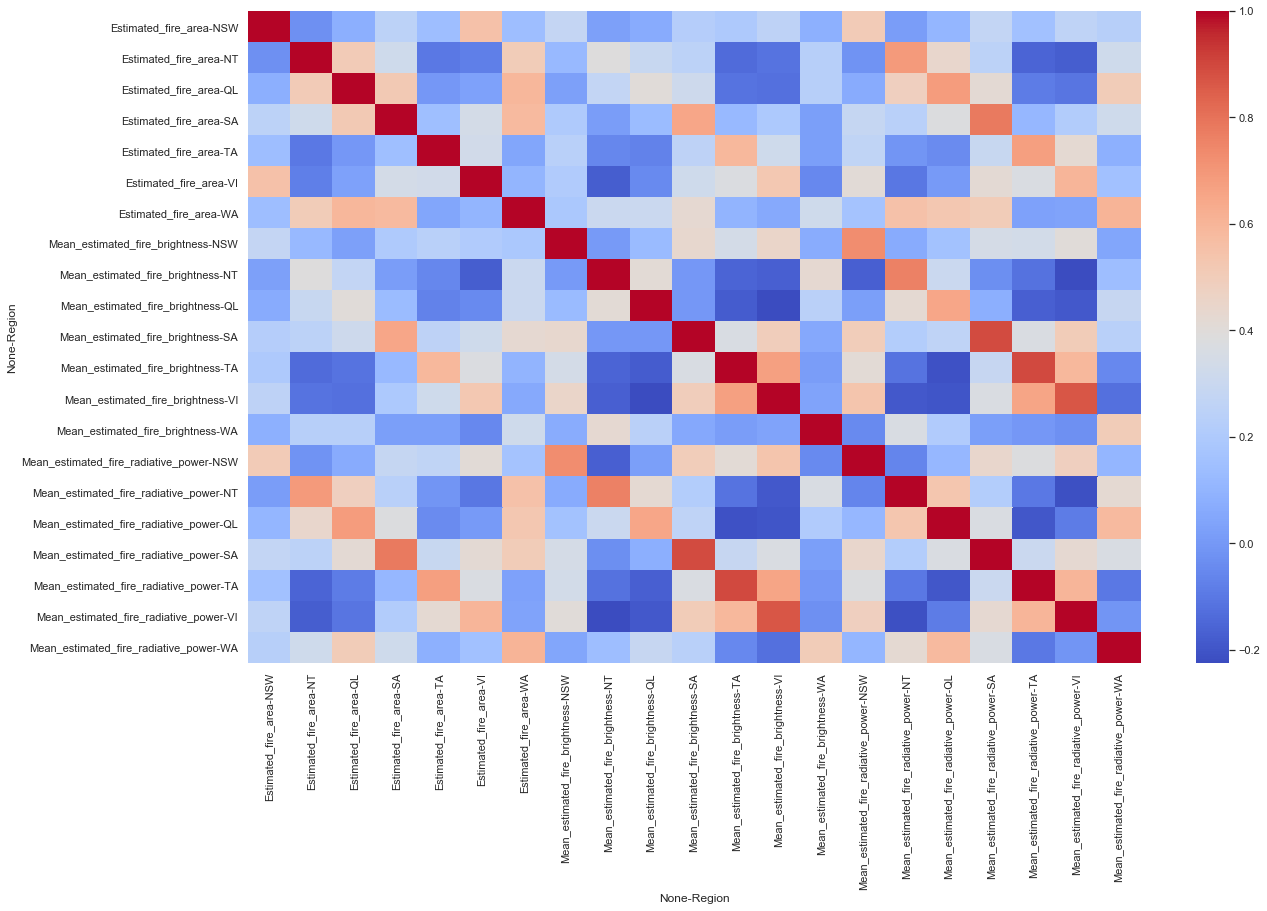

In [501]:
wants = ["Estimated_fire_area", 
         "Mean_estimated_fire_brightness", 
         "Mean_estimated_fire_radiative_power"]

df_30 = period(fire, days = 30, columns = wants)

plt.figure(figsize = (20, 12))
sns.heatmap(df_30.corr(), cmap = "coolwarm", xticklabels = True, yticklabels = True)

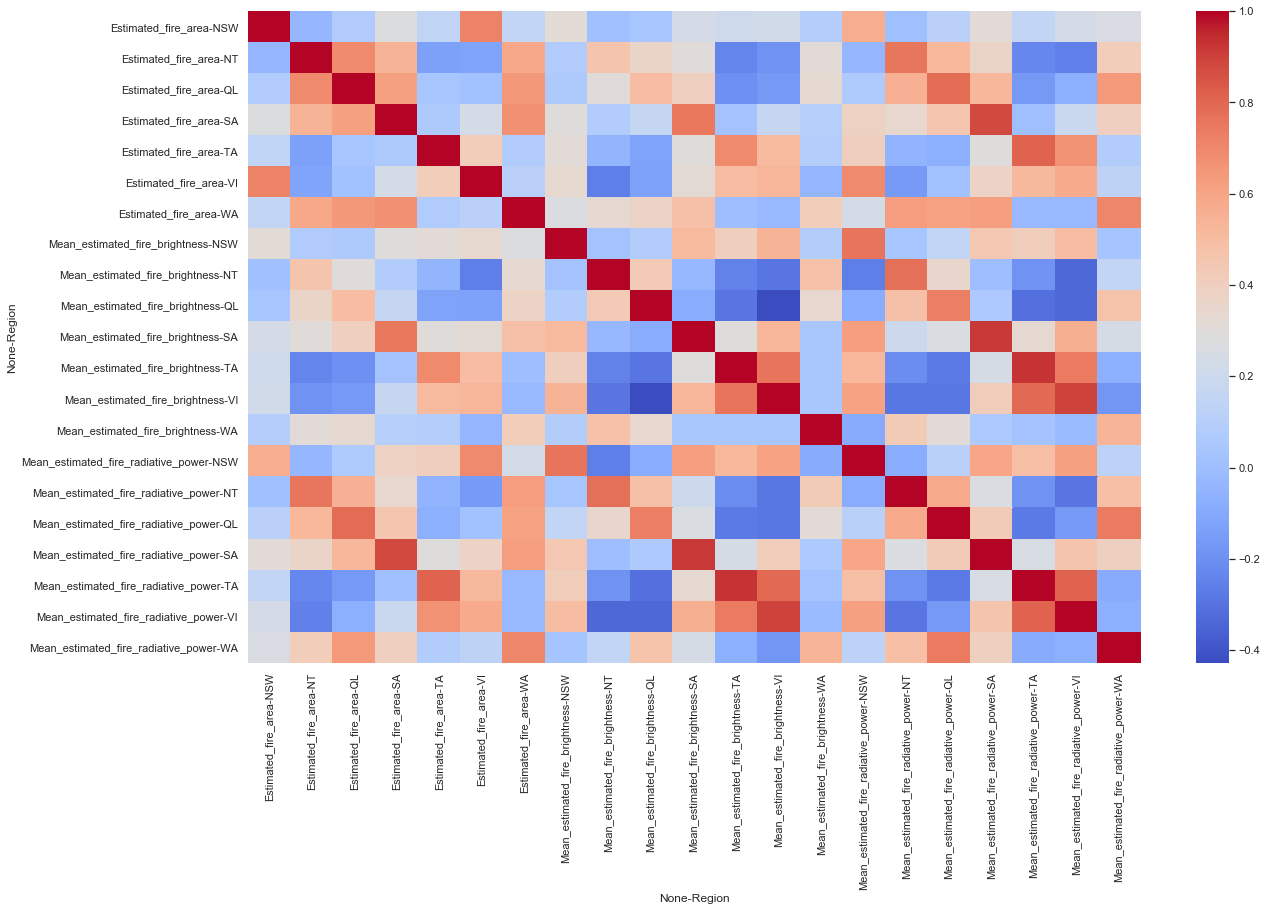

In [502]:
df_30 = period(fire, days = 90, columns = wants)

plt.figure(figsize = (20, 12))
sns.heatmap(df_30.corr(), cmap = "coolwarm", xticklabels = True, yticklabels = True)

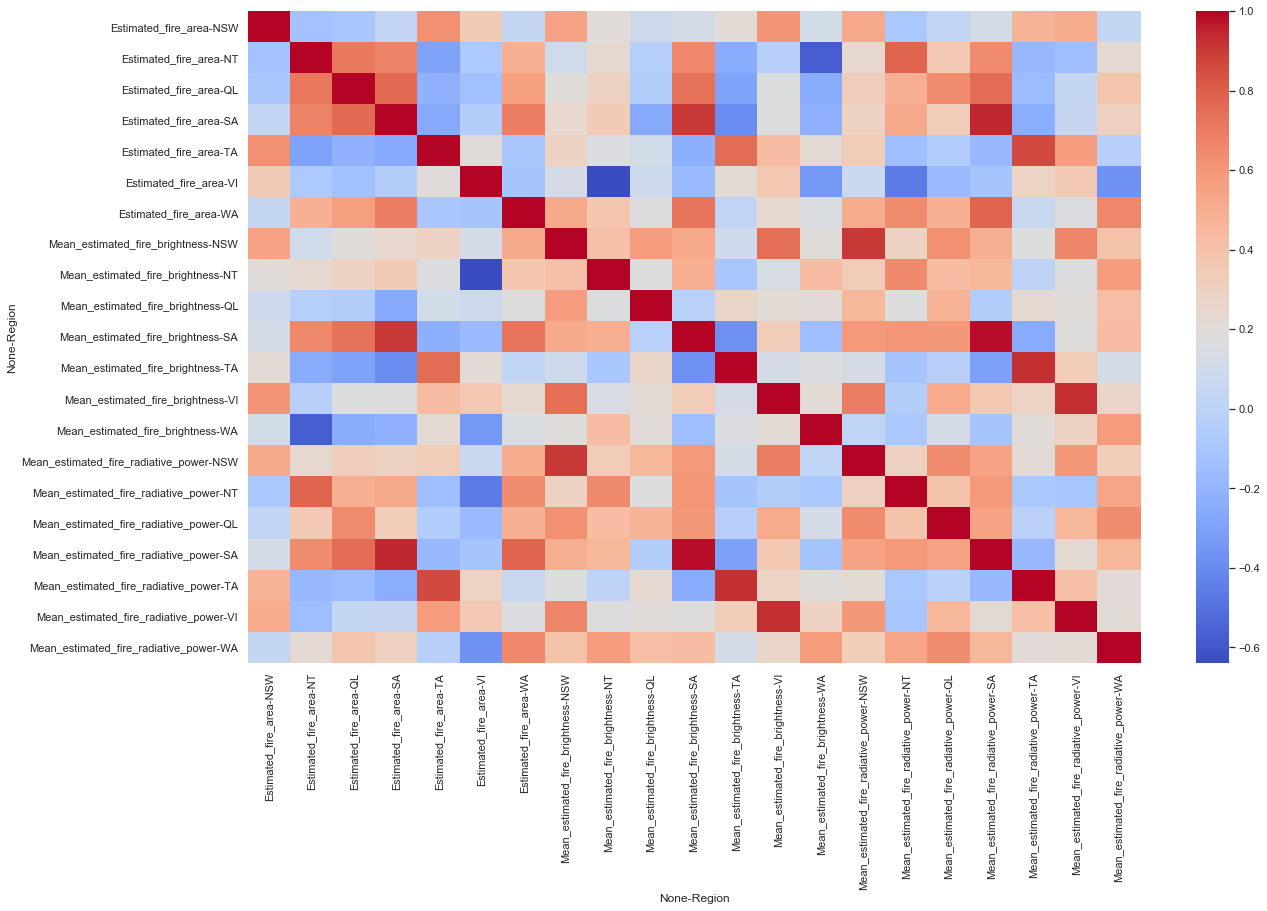

In [503]:
df_30 = period(fire, days = 365, columns = wants)

plt.figure(figsize = (20, 12))
sns.heatmap(df_30.corr(), cmap = "coolwarm", xticklabels = True, yticklabels = True)

In [579]:
def filter(ori, region = None, start_date = "01-01-2005", end_date = "01-01-2022"):
    df = ori.copy()
    df = df[(start_date <= df["Date"]) & (df["Date"] <= end_date)]
    if region != None:
        if isinstance(region, list):
            df = df[df["Region"].isin(region)]
        else:
            df = df[df["Region"] == region]
    return df

def plot_yearly(df, columns = None):
    df = df.groupby("Date").median()

    idx = pd.MultiIndex.from_arrays([
            pd.to_datetime(df.index.strftime('2012-%m-%d %H:%M:%S')),
            df.index.year])

    d1 = df.set_index(idx).unstack().resample("W").median()
        
    if columns == None:
        columns = d1.columns
       
    fig, axes = plt.subplots(len(columns), 1, figsize=(15, len(columns) * 3))
    idx = 0
    for col in columns:
        d1[col].plot(ax = axes[idx], title = col)
        legend = axes[idx].legend()
        legend.remove()
        idx += 1
        
    plt.show()
    
def plot_monthly(df, columns = None):
    df = df.groupby("Date").median()
    
    df["Day"] = pd.to_datetime(df.index.strftime('2012-1-%d %H:%M:%S'))
    df["Month"] = [date.month for date in df.index]
    
    df = df.groupby(["Month", "Day"]).median()
    df = df.reset_index("Month")
    
#     return df
    
    if columns == None:
        columns = df.columns
        
    fig, axes = plt.subplots(len(columns), 1, figsize=(15, len(columns) * 3))
    idx = 0
    for col in columns:
        sns.set(style="whitegrid")
        sns.lineplot(x = df.index, y = col, hue = "Month", ax = axes[idx], data = df)
#         df[col].plot(ax = axes[idx], title = col)
#         legend = axes[idx].legend()
#         legend.remove()
        idx += 1
        
    plt.show()
    
def plot_k_month(df, columns = None, k = 3):
    df = df.groupby("Date").median()

    idx = pd.MultiIndex.from_arrays([
            pd.to_datetime(df.index.strftime('2012-%m-%d %H:%M:%S')),
            df.index.year])

    d1 = df.set_index(idx).unstack().resample("W").median()
    
    return d1
        
    if columns == None:
        columns = d1.columns
       
    fig, axes = plt.subplots(len(columns), 1, figsize=(15, len(columns) * 3))
    idx = 0
    for col in columns:
        d1[col].plot(ax = axes[idx], title = col)
        legend = axes[idx].legend()
        legend.remove()
        idx += 1
        
    plt.show()
        
east = ["NSW", "TA", "VI"]
west = ["NT", "QL", "SA", "WA"]

KeyError: 'WindSpeed_max'

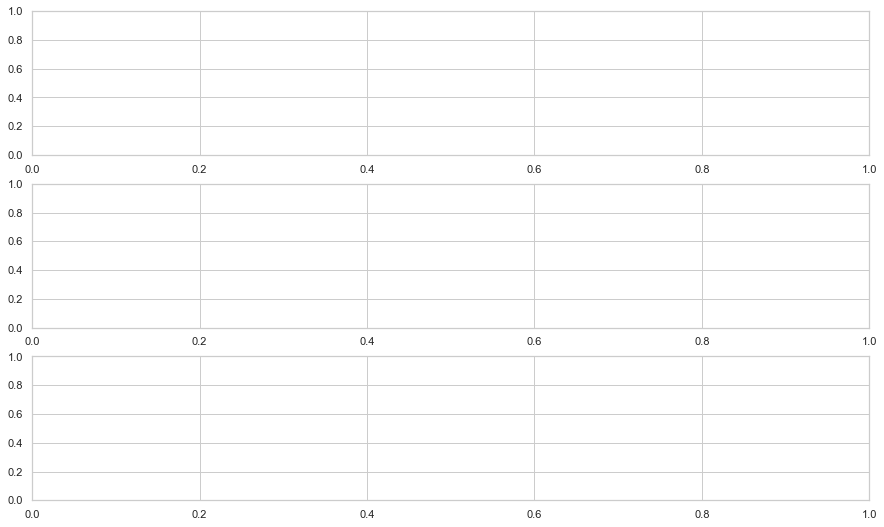

In [580]:
plot_yearly(filter(fire, region = east), columns = wants)

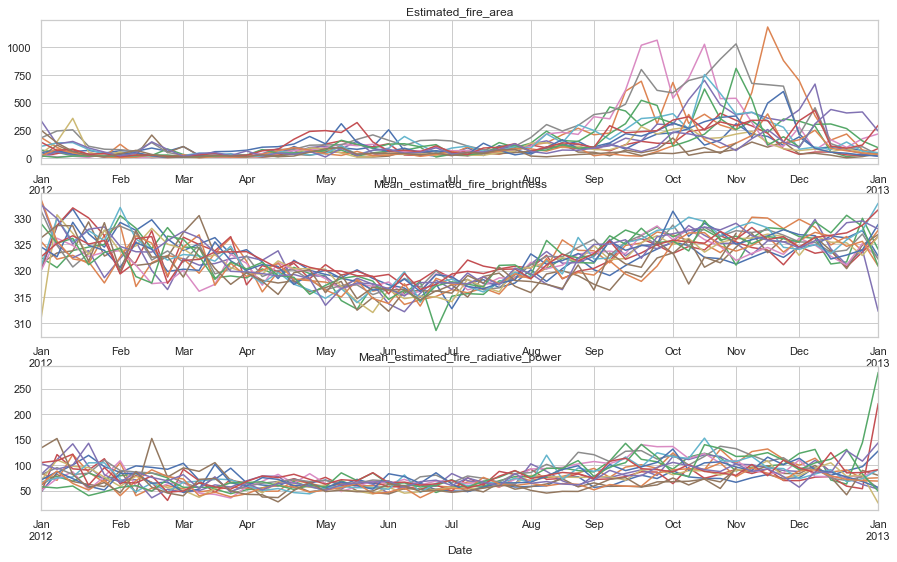

In [505]:
plot_yearly(filter(fire, region = west), columns = wants)

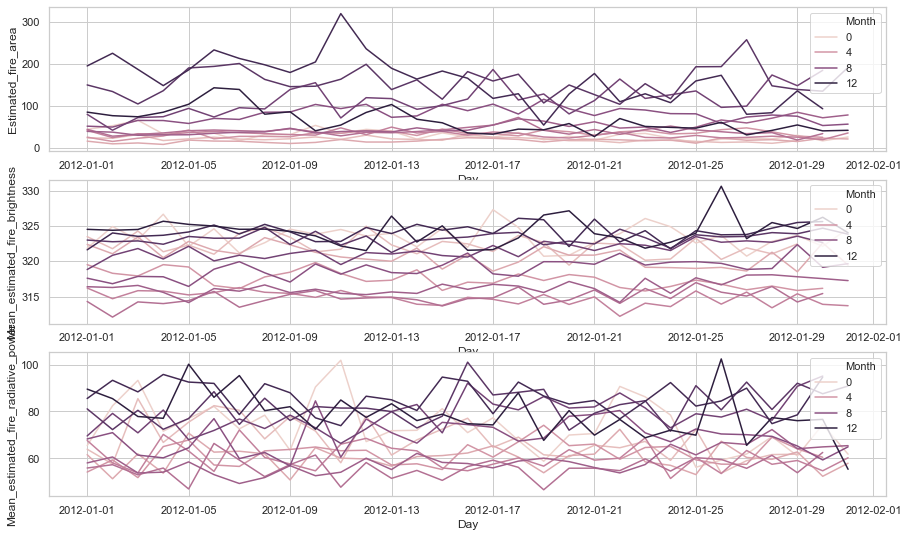

In [506]:
plot_monthly(fire, columns = wants)

# Historical Weather

In [510]:
weather = pd.read_csv("Nov_10/HistoricalWeather.csv")
weather = clean(weather)

weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242781 entries, 0 to 242780
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Date                 242781 non-null  datetime64[ns]
 1   Region               242781 non-null  object        
 2   Parameter            242781 non-null  object        
 3   count()[unit: km^2]  242781 non-null  float64       
 4   min()                242781 non-null  float64       
 5   max()                242781 non-null  float64       
 6   mean()               242781 non-null  float64       
 7   variance()           242781 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 14.8+ MB


In [522]:
weather.head()

Date Region         Parameter  count()[unit: km^2]      min()  \
0 2005-01-01    NSW     Precipitation        800234.348986   0.000000   
1 2005-01-01    NSW  RelativeHumidity        800234.348986  13.877194   
2 2005-01-01    NSW  SoilWaterContent        800234.348986   0.002245   
3 2005-01-01    NSW    SolarRadiation        800234.348986  14.515009   
4 2005-01-01    NSW       Temperature        800234.348986  14.485785   

       max()     mean()  variance()  
0   1.836935   0.044274    0.028362  
1  80.522964  36.355567  253.559937  
2   0.414305   0.170931    0.007758  
3  32.169781  26.749389    6.078587  
4  35.878704  27.341182   18.562212

In [513]:
df_pivot = weather.rename(columns = {"min()": "min", "max()": "max", "mean()": "mean"})
df_pivot = df_pivot.pivot_table(
    columns = ["Parameter"], 
    values = ["min", "max", "mean"],
    index = ["Date", "Region"])

df_pivot.reset_index(inplace=True)

df_pivot.columns = [col[0] if not(col[1]) else '{1}_{0}'.format(*col) for col in df_pivot.columns.values]

params = df_pivot.columns.tolist()[3:]
params.sort()
weather_data = df_pivot[df_pivot.columns.tolist()[:3] + params].copy()
weather_data.head()

Date Region  Precipitation_max  Precipitation_mean  Precipitation_min  \
0 2005-01-01    NSW           1.836935            0.044274           0.000000   
1 2005-01-01     NT         315.266815            9.884958           0.000000   
2 2005-01-01     QL          74.452164            1.453053           0.000000   
3 2005-01-01     SA           3.193624            0.059078           0.000000   
4 2005-01-01     TA          13.604791            3.099497           0.003973   

   RelativeHumidity_max  RelativeHumidity_mean  RelativeHumidity_min  \
0             80.522964              36.355567             13.877194   
1             95.683342              61.494675             14.558820   
2             95.898270              47.959364             14.443199   
3             81.980751              30.057683             10.618136   
4             81.501442              65.086764             43.906574   

   SoilWaterContent_max  SoilWaterContent_mean  SoilWaterContent_min  \
0              0.414305               0.170931              0.002245   
1              0.496140               0.167735              0.000000   
2              0.472416               0.185641              0.000000   
3              0.263911               0.056047              0.000000   
4              0.368189               0.211360              0.000000   

   SolarRadiation_max  SolarRadiation_mean  SolarRadiation_min  \
0           32.169781            26.749389           14.515009   
1           31.634459            19.781791            2.518120   
2           31.982830            27.056979            6.033827   
3           31.734528            27.142643           17.861103   
4           33.225517            26.755711           20.742302   

   Temperature_max  Temperature_mean  Temperature_min  WindSpeed_max  \
0        35.878704         27.341182        14.485785       7.670482   
1        38.136787         29.881492        24.179960       9.704402   
2        37.047943         28.842866        20.951620       7.675632   
3        38.326847         30.793675        14.095855      10.044715   
4        16.228510         11.788805         6.686816      11.432408   

   WindSpeed_mean  WindSpeed_min  
0        3.323550       1.354448  
1        5.296892       1.840394  
2        3.483753       1.106028  
3        4.657538       2.023657  
4        5.408138       1.995647

Precipitation
['Precipitation_max', 'Precipitation_mean', 'Precipitation_min']


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


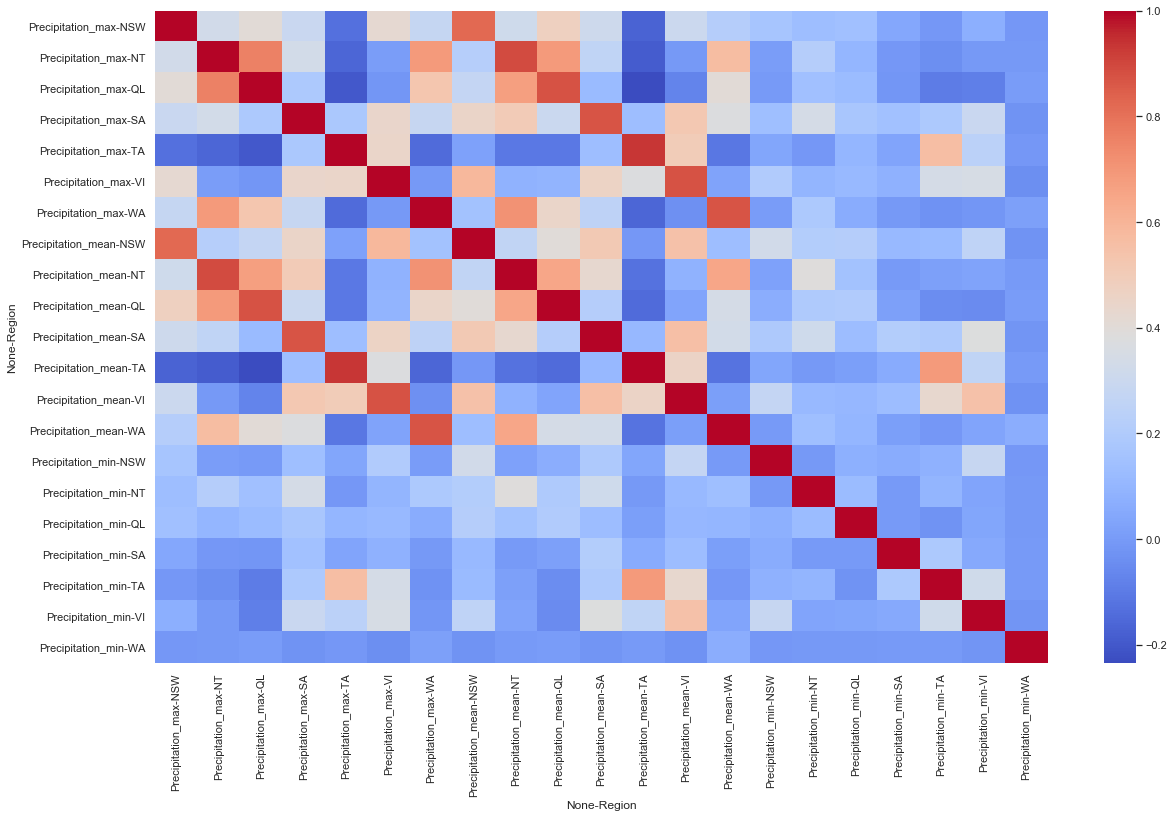

RelativeHumidity
['RelativeHumidity_max', 'RelativeHumidity_mean', 'RelativeHumidity_min']


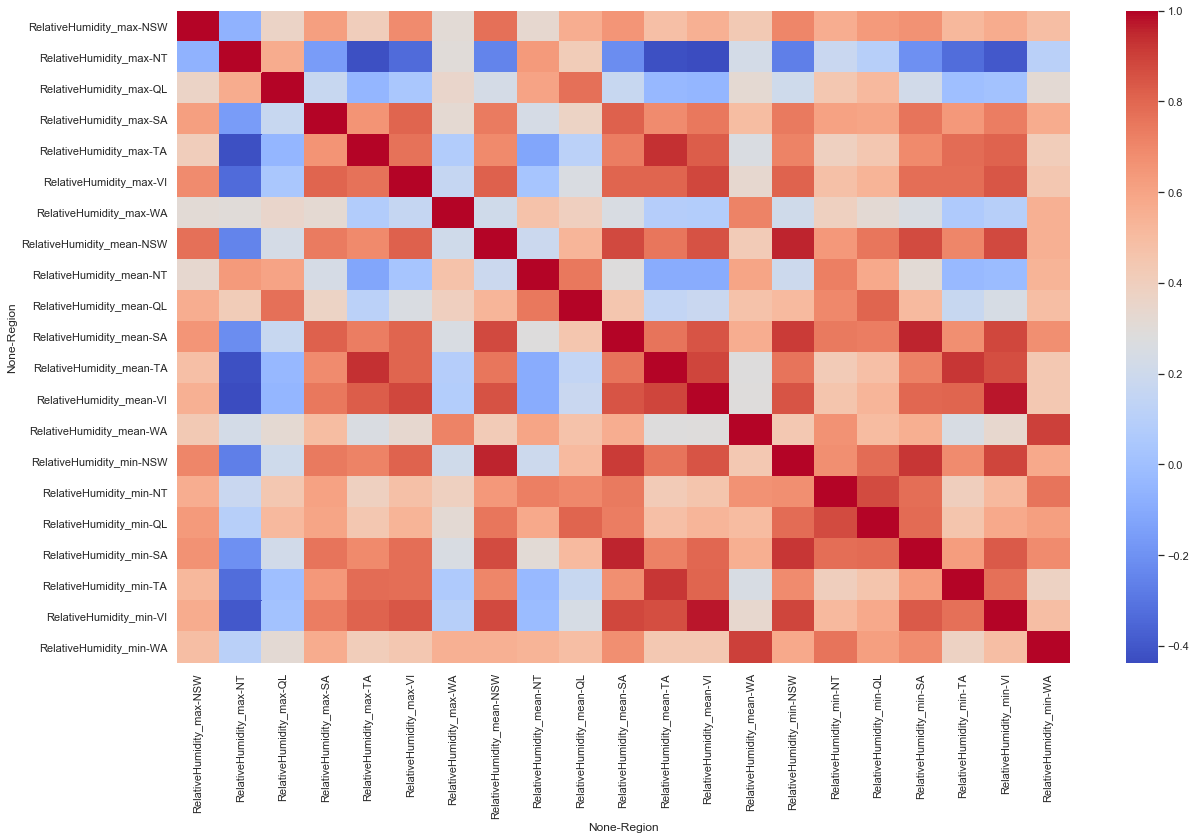

SoilWaterContent
['SoilWaterContent_max', 'SoilWaterContent_mean', 'SoilWaterContent_min']


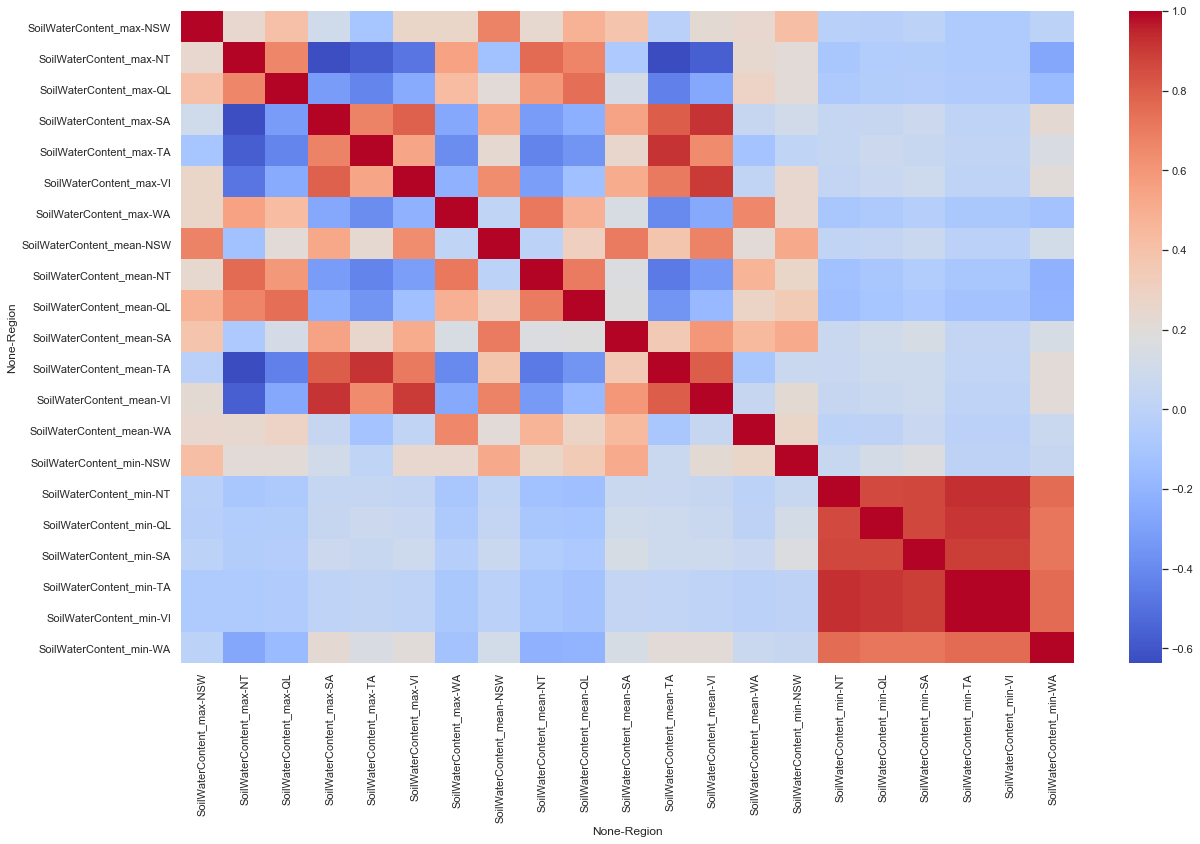

SolarRadiation
['SolarRadiation_max', 'SolarRadiation_mean', 'SolarRadiation_min']


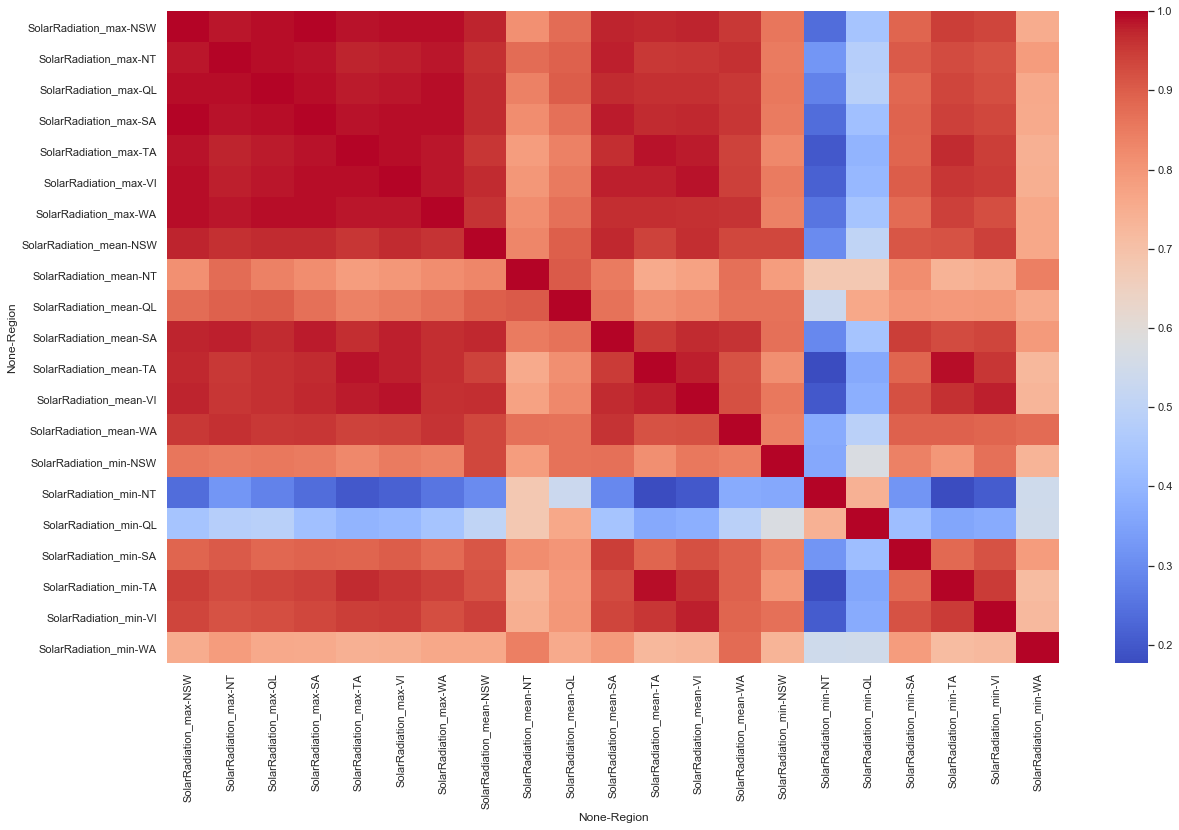

Temperature
['Temperature_max', 'Temperature_mean', 'Temperature_min']


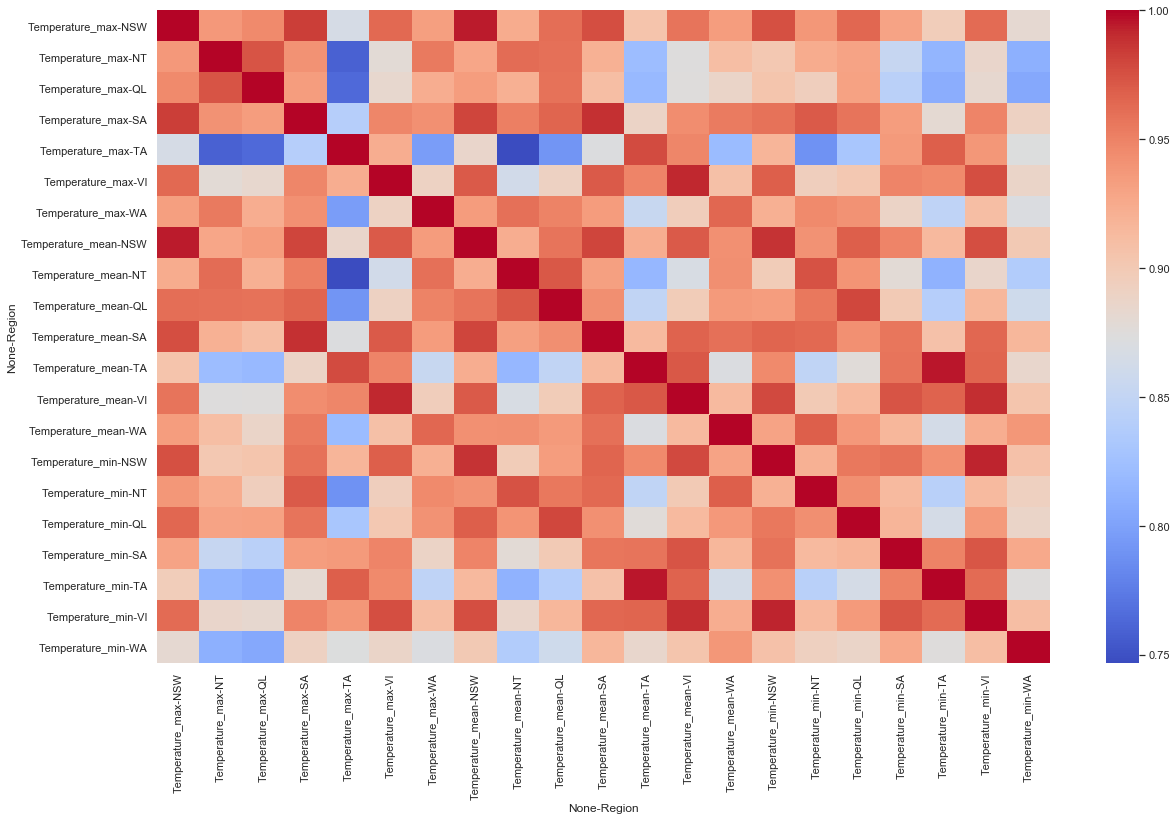

WindSpeed
['WindSpeed_max', 'WindSpeed_mean', 'WindSpeed_min']


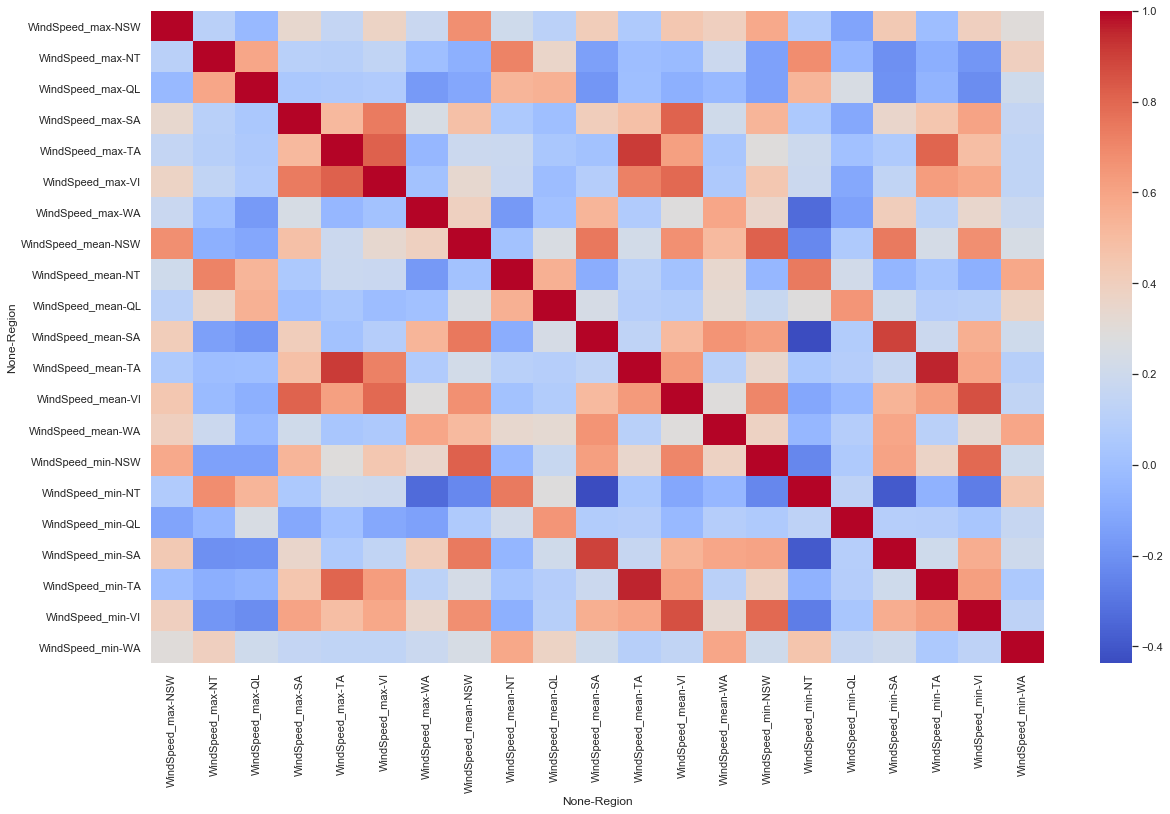

In [524]:
params = np.unique(weather["Parameter"])
for param in params:
    print(param)
    wants = [param + "_" + x for x in ["max", "mean", "min"]]
    print(wants)

    df = period(weather_data, days = 10, columns = wants)

    plt.figure(figsize = (20, 12))
    sns.heatmap(df.corr(), cmap = "coolwarm", xticklabels = True, yticklabels = True)
    plt.show()

Precipitation
['Precipitation_max', 'Precipitation_mean', 'Precipitation_min']


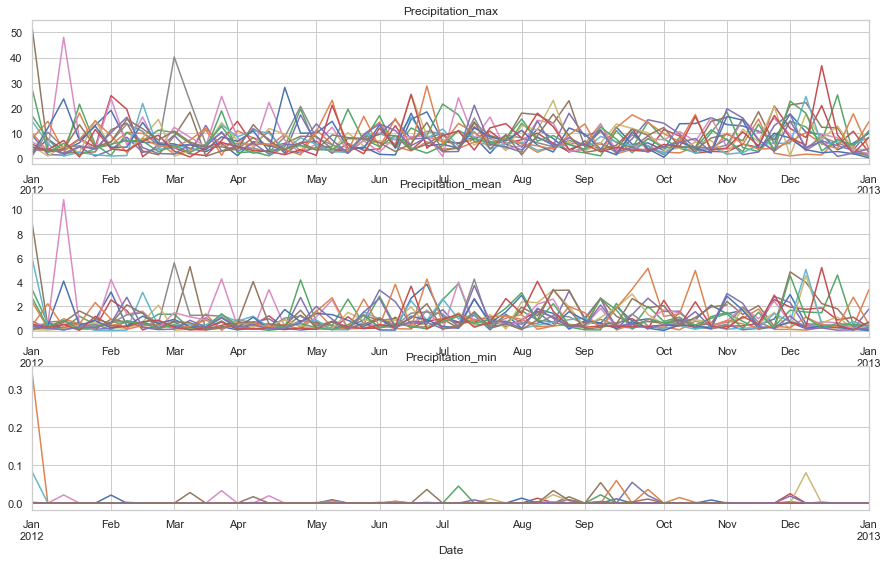

RelativeHumidity
['RelativeHumidity_max', 'RelativeHumidity_mean', 'RelativeHumidity_min']


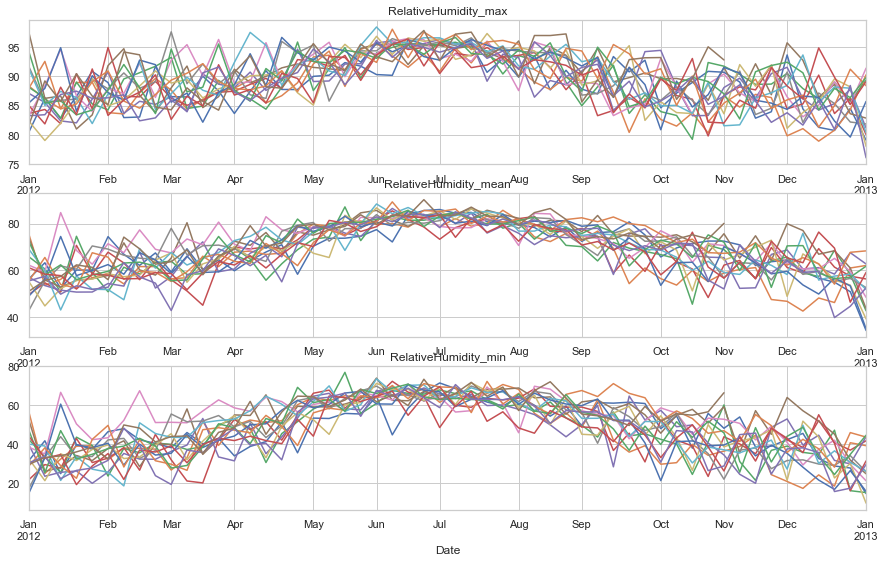

SoilWaterContent
['SoilWaterContent_max', 'SoilWaterContent_mean', 'SoilWaterContent_min']


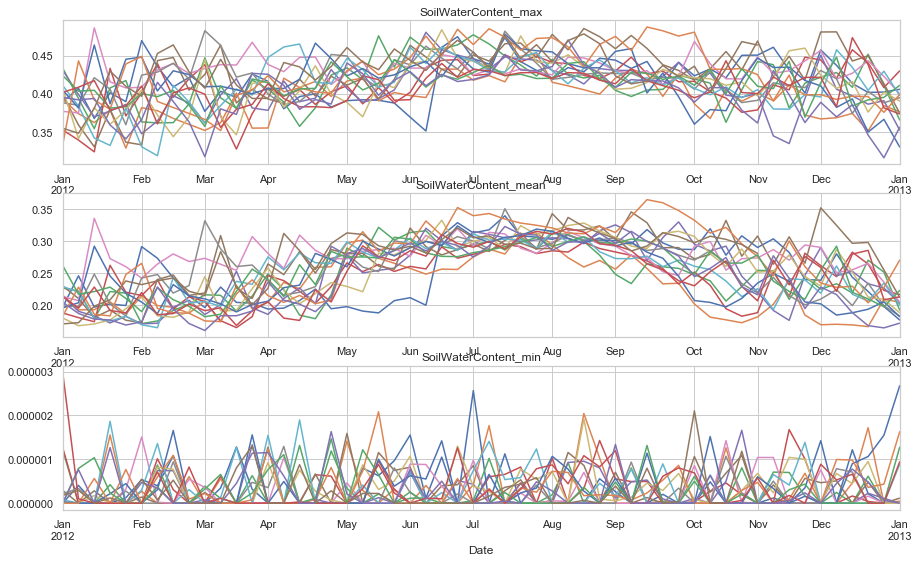

SolarRadiation
['SolarRadiation_max', 'SolarRadiation_mean', 'SolarRadiation_min']


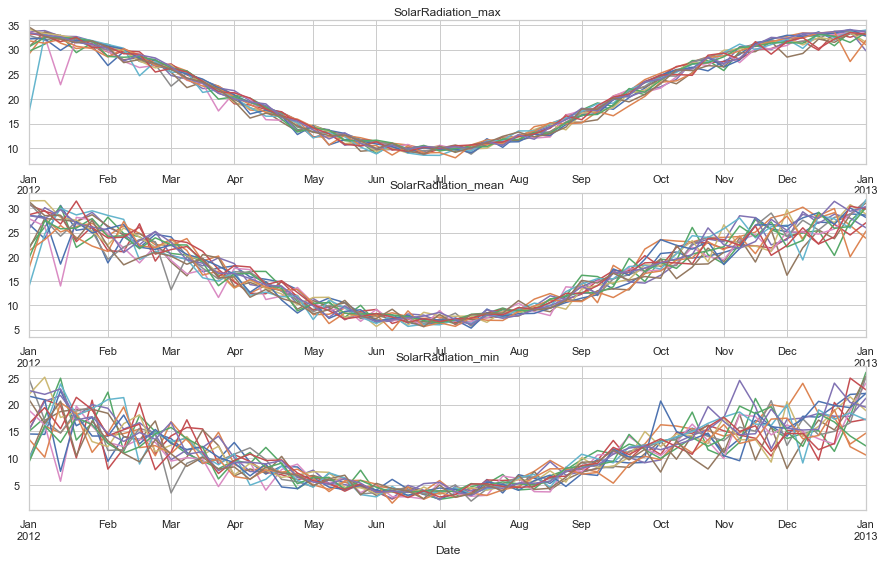

Temperature
['Temperature_max', 'Temperature_mean', 'Temperature_min']


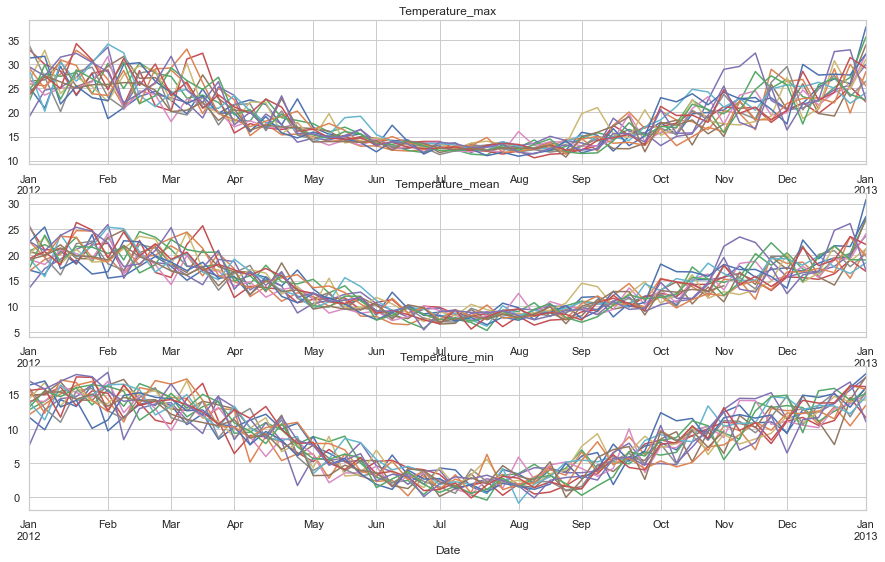

WindSpeed
['WindSpeed_max', 'WindSpeed_mean', 'WindSpeed_min']


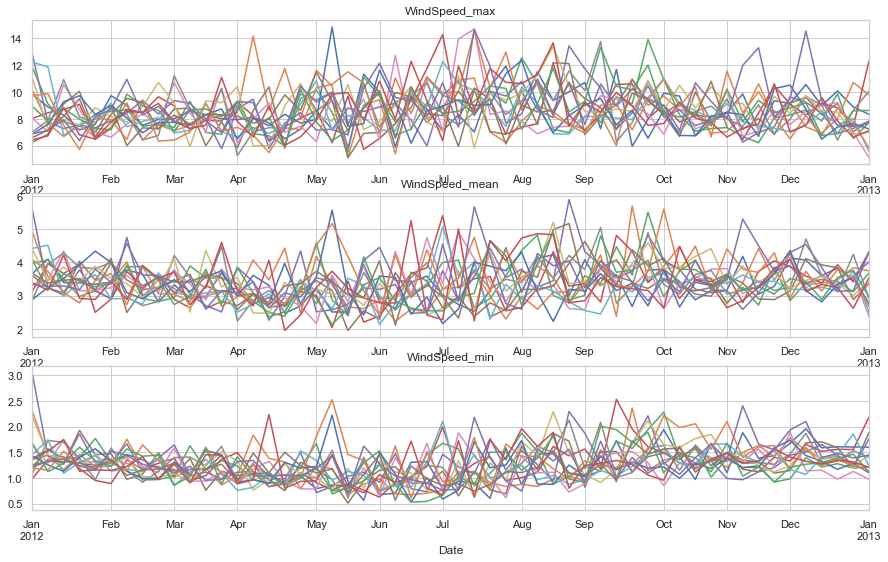

In [538]:
params = np.unique(weather["Parameter"])
for param in params:
    print(param)
    wants = [param + "_" + x for x in ["max", "mean", "min"]]
    print(wants)
    plot_yearly(filter(weather_data, region = east), columns = wants)

Precipitation
['Precipitation_max', 'Precipitation_mean', 'Precipitation_min']


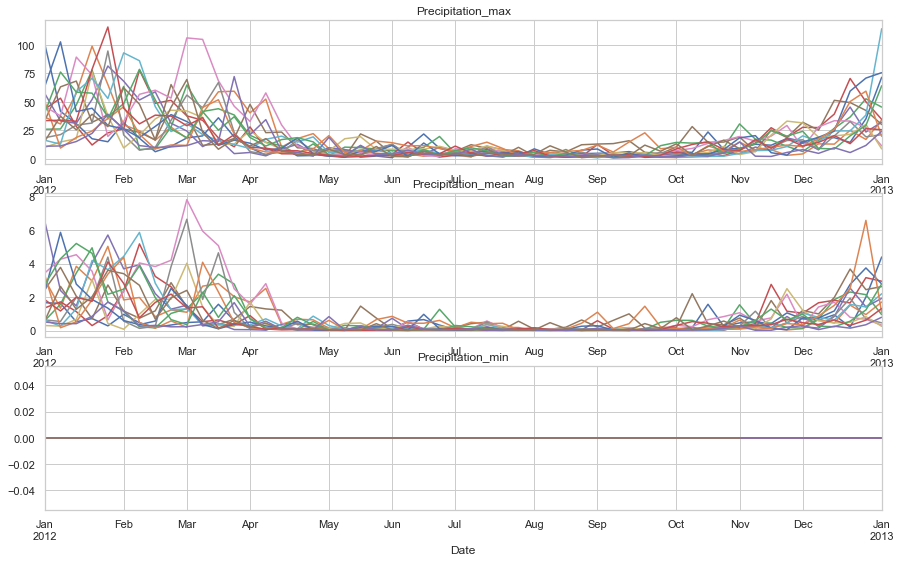

RelativeHumidity
['RelativeHumidity_max', 'RelativeHumidity_mean', 'RelativeHumidity_min']


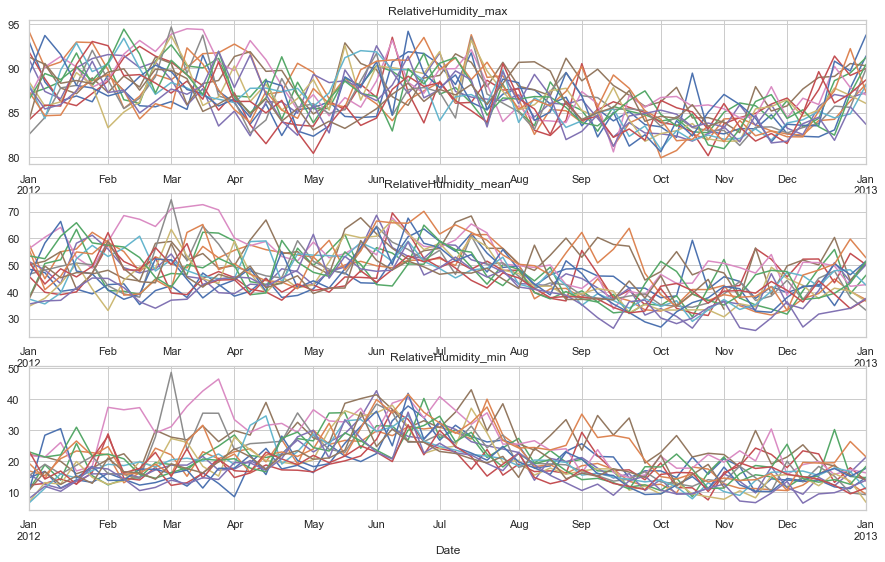

SoilWaterContent
['SoilWaterContent_max', 'SoilWaterContent_mean', 'SoilWaterContent_min']


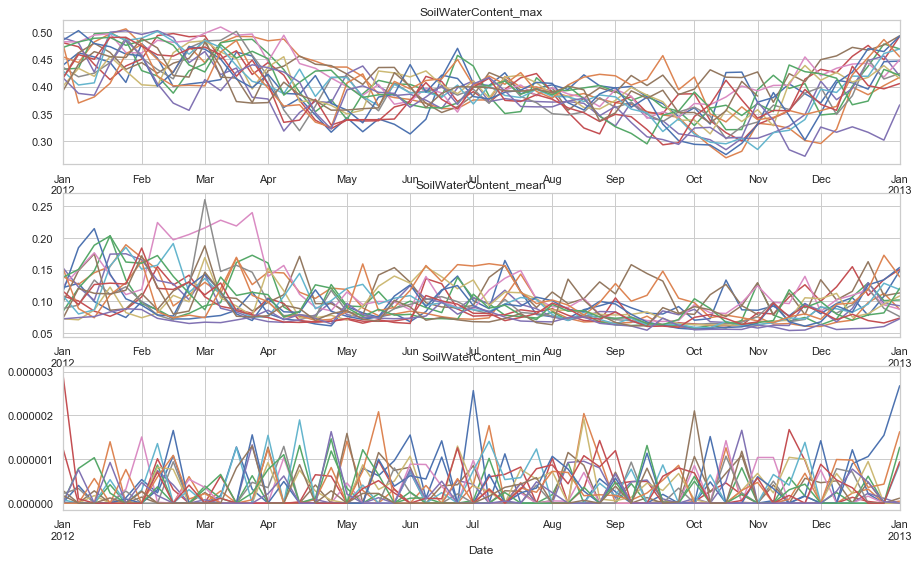

SolarRadiation
['SolarRadiation_max', 'SolarRadiation_mean', 'SolarRadiation_min']


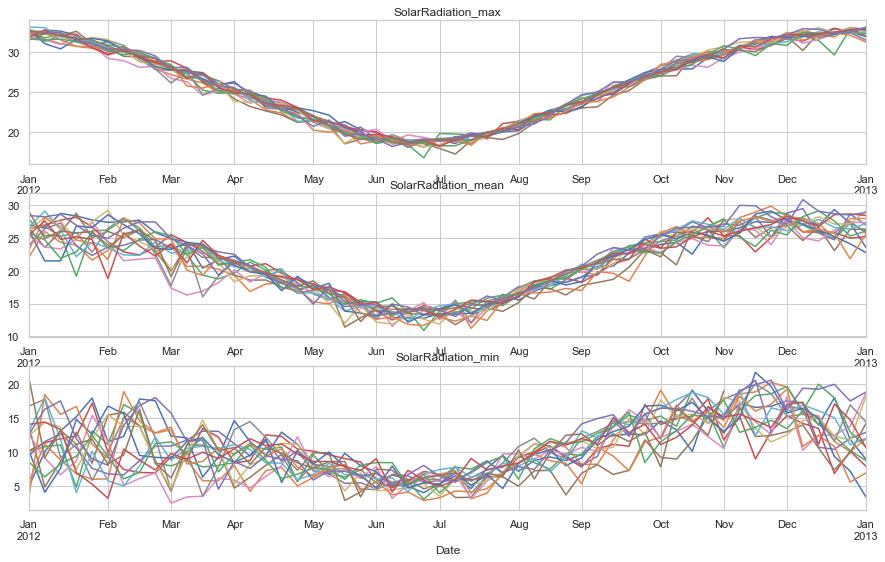

Temperature
['Temperature_max', 'Temperature_mean', 'Temperature_min']


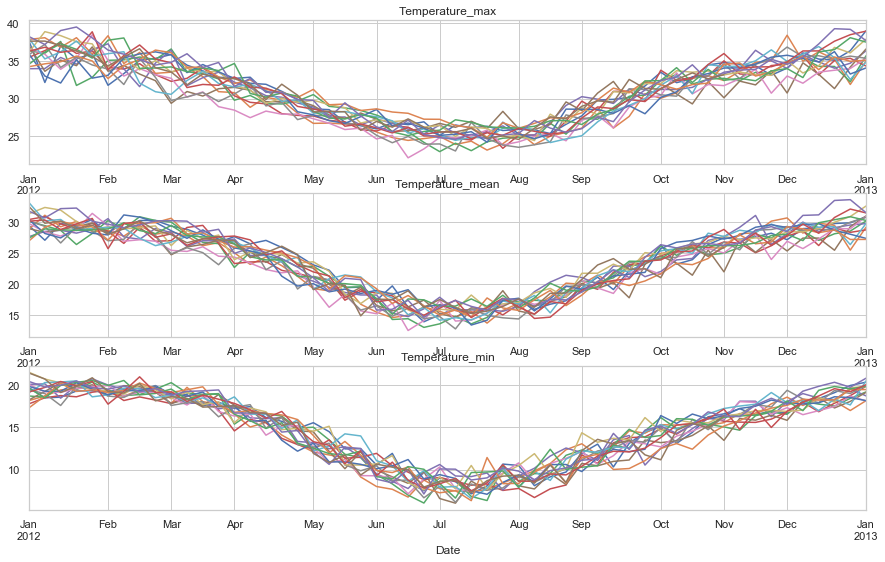

WindSpeed
['WindSpeed_max', 'WindSpeed_mean', 'WindSpeed_min']


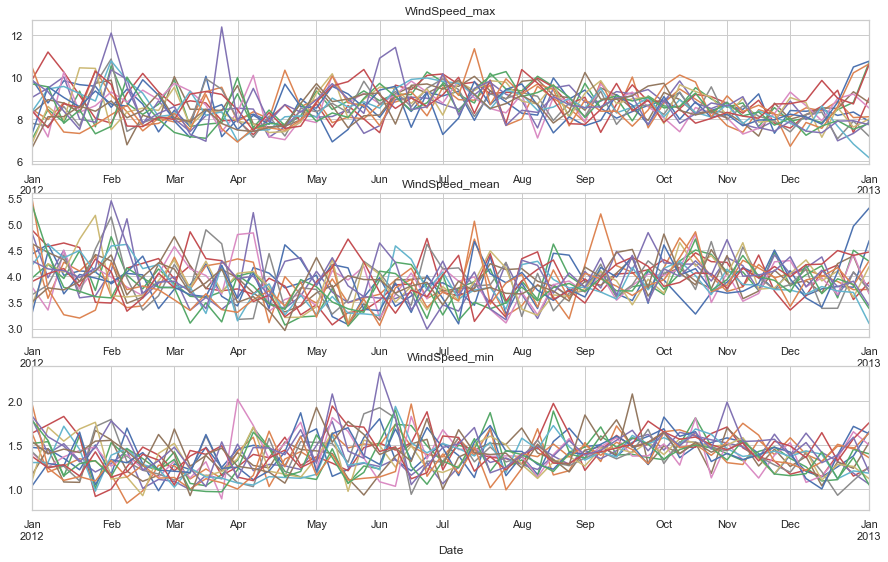

In [539]:
params = np.unique(weather["Parameter"])
for param in params:
    print(param)
    wants = [param + "_" + x for x in ["max", "mean", "min"]]
    print(wants)
    plot_yearly(filter(weather_data, region = west), columns = wants)

Precipitation
['Precipitation_max', 'Precipitation_mean', 'Precipitation_min']


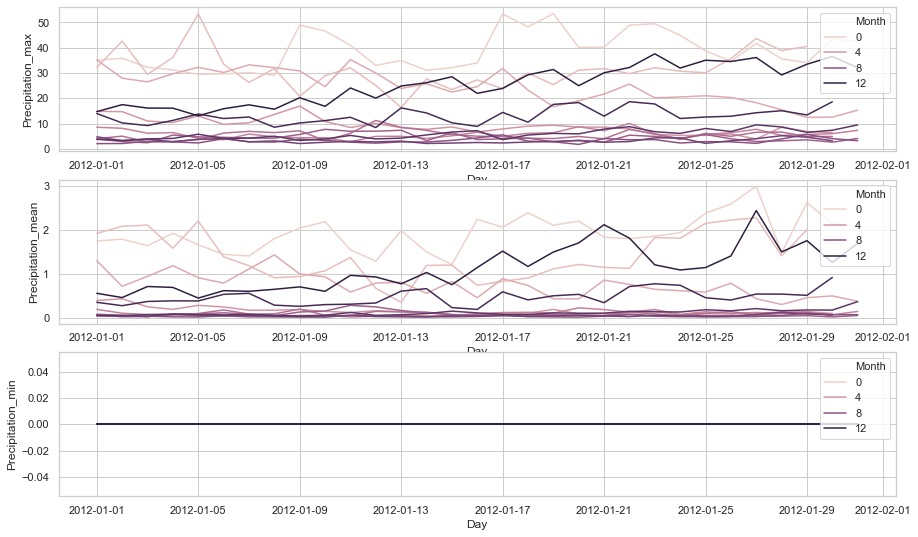

RelativeHumidity
['RelativeHumidity_max', 'RelativeHumidity_mean', 'RelativeHumidity_min']


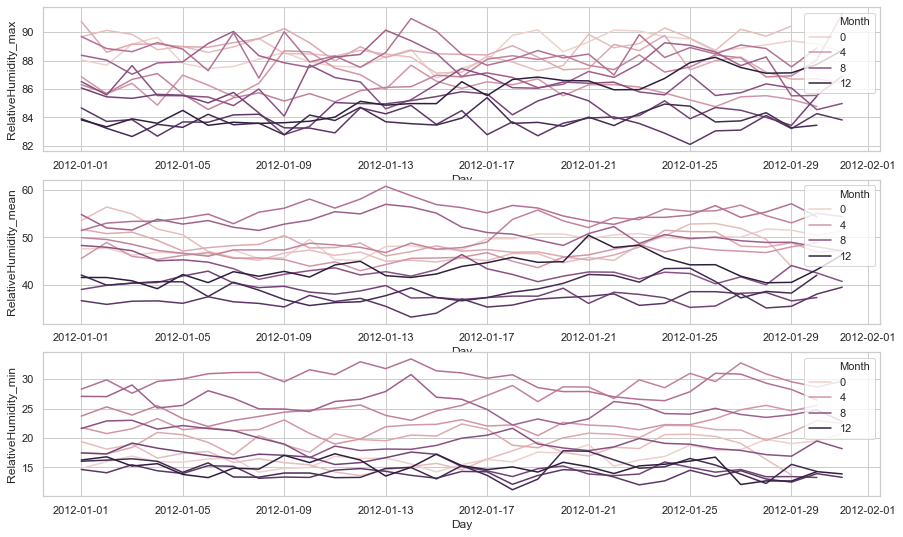

SoilWaterContent
['SoilWaterContent_max', 'SoilWaterContent_mean', 'SoilWaterContent_min']


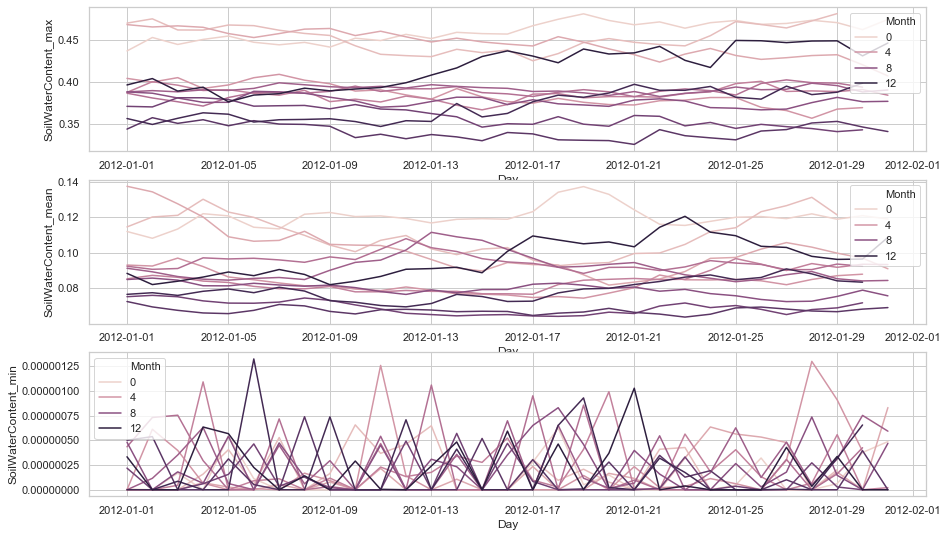

SolarRadiation
['SolarRadiation_max', 'SolarRadiation_mean', 'SolarRadiation_min']


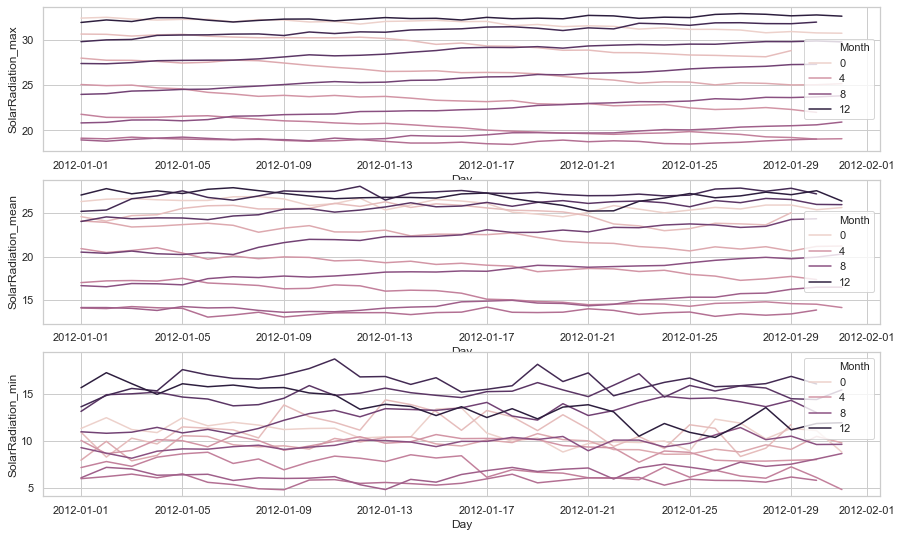

Temperature
['Temperature_max', 'Temperature_mean', 'Temperature_min']


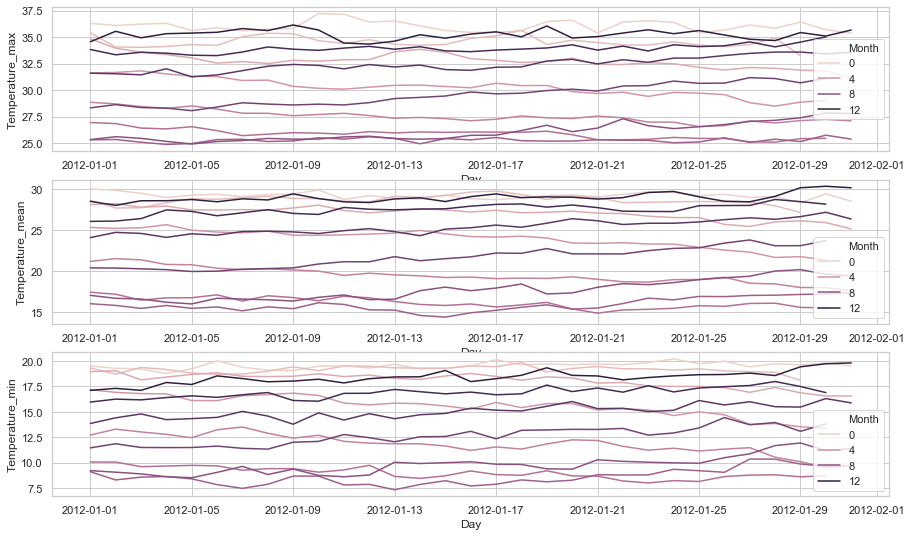

WindSpeed
['WindSpeed_max', 'WindSpeed_mean', 'WindSpeed_min']


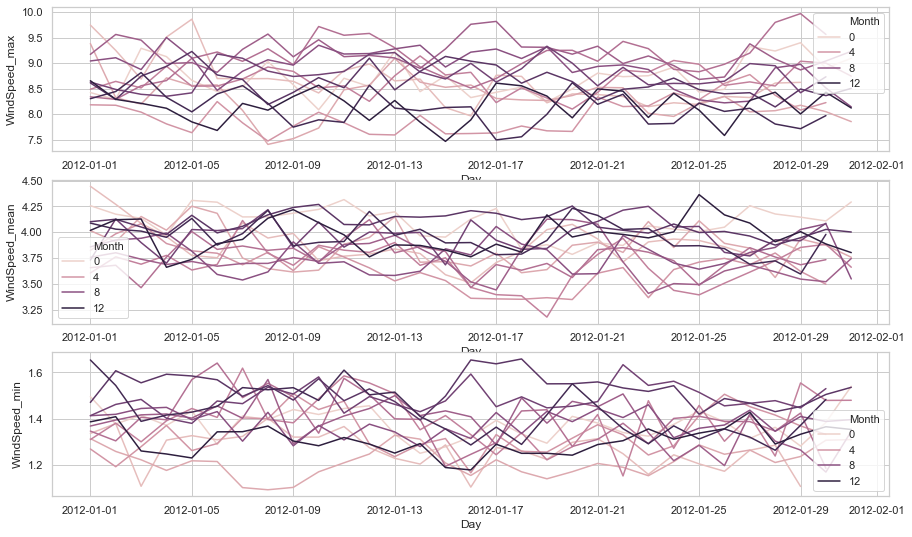

In [554]:
params = np.unique(weather["Parameter"])
for param in params:
    print(param)
    wants = [param + "_" + x for x in ["max", "mean", "min"]]
    print(wants)
    plot_monthly(filter(weather_data, region = west), columns = wants)

# All data

In [531]:
all = fire.merge(weather_data, on = ["Region", "Date"])

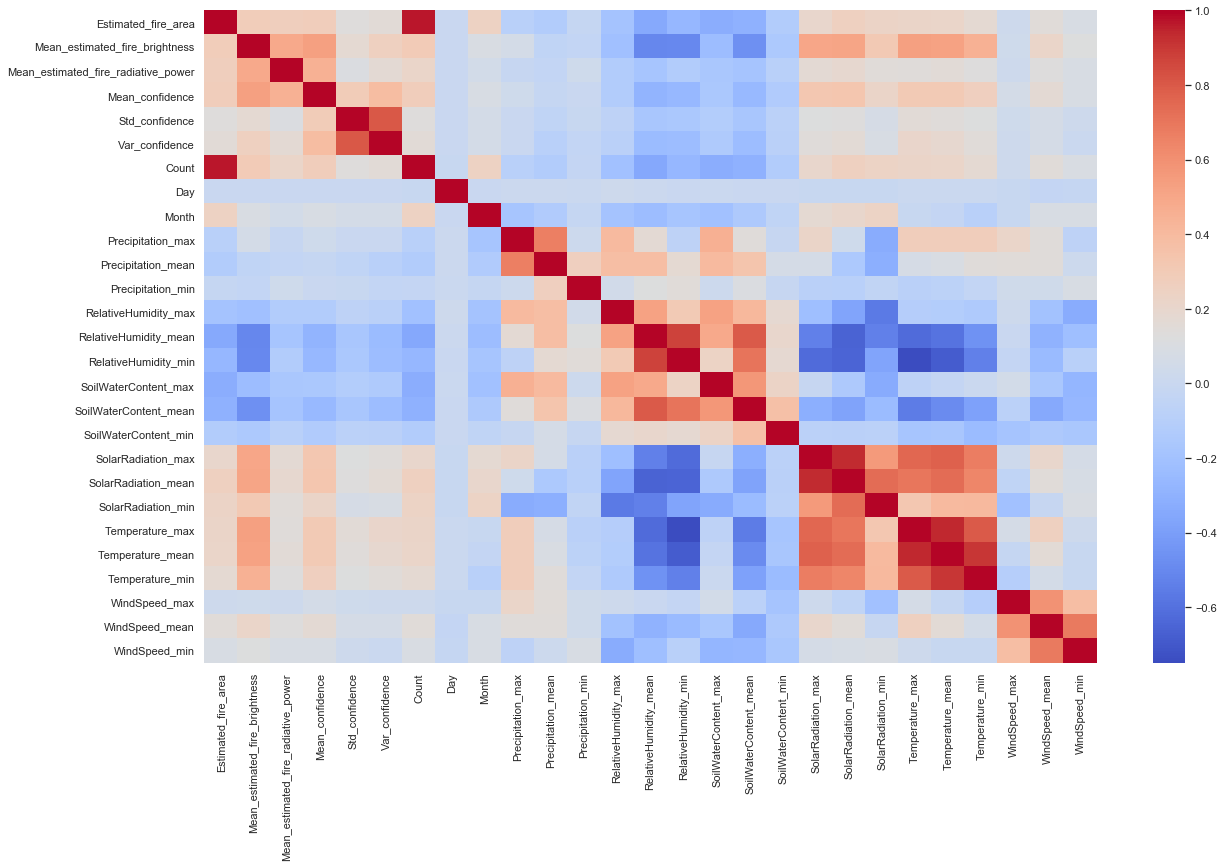

In [535]:
plt.figure(figsize = (20, 12))
sns.heatmap(all.corr(), cmap = "coolwarm", xticklabels = True, yticklabels = True)
plt.show()

In [559]:
zap = pd.read_csv("./lightning.csv")

In [560]:
zap

Lightning ID            Date/Time  Latitude  Longitude State  \
0           333  2016-12-05 17:50:00  -28.3984   153.2678   NSW   

                     Severity confidence description  Damage total  Unnamed: 7  
0  based on actual observation of event by Bureau...           NaN         NaN

In [565]:
len(weather_data)

40481

In [566]:
len(fire)

26406

In [573]:
from datetime import date, timedelta, datetime

def find_missing_date(df, start_date = (2005,1,1), end_date = (2020,10,31), 
                      region = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA'], date_col = 'Date') :

    df[date_col] = pd.to_datetime(df[date_col])
    start_date = date(start_date[0], start_date[1], start_date[2])
    end_date = date(end_date[0], end_date[1], end_date[2])
    total_date_set = set([start_date + timedelta(x) for x in range((end_date- start_date).days)])
    
    missing = dict()
    for reg in region : 
        df_temp = df[df['Region'] == reg]
        date_list = list(df_temp[date_col])
        date_set = set([ts.date() for ts in date_list])
        
        missing[reg] = total_date_set - date_set
        
    return missing

In [577]:
reg = find_missing_date(fire)
for x, y in reg.items():
    z = len(fire[fire["Region"] == x])
    print(x, len(y), z)

NSW 1160 4623
NT 730 5053
QL 250 5533
SA 3792 1990
TA 4378 1404
VI 3606 2176
WA 156 5627


In [575]:
find_missing_date(weather_data)

{'NSW': set(),
 'NT': set(),
 'QL': set(),
 'SA': set(),
 'TA': set(),
 'VI': set(),
 'WA': set()}